MOUNTING DRIVE

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CREATING A FOLDER STRUCTURE

In [8]:
import os

# New root project folder
project_root = "/content/drive/MyDrive/GrainPalette_RiceTypeDetection"
subset_path = os.path.join(project_root, "Rice_Image_Subset")

# Classes
classes = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Create folders: train/val/test subdirectories for each class
for split in ["train", "val", "test"]:
    for cls in classes:
        dir_path = os.path.join(subset_path, split, cls)
        os.makedirs(dir_path, exist_ok=True)

print("✅ Folder structure created successfully at:\n", subset_path)


✅ Folder structure created successfully at:
 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset


Creating Subset dataset (copying images) to created folder

In [9]:
import os
import random
import shutil

# Paths
source_dataset_path = "/content/drive/MyDrive/GrainPaletteRiceProject/rice_dataset/Rice_Image_Dataset"
target_base_path = "/content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset"

# Class names
classes = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

# Number of images to copy per split
split_sizes = {
    "train": 150,
    "val": 30,
    "test": 20
}

# For each class
for cls in classes:
    source_class_dir = os.path.join(source_dataset_path, cls)
    all_images = os.listdir(source_class_dir)
    random.shuffle(all_images)  # shuffle to avoid bias

    start_idx = 0
    for split, count in split_sizes.items():
        split_images = all_images[start_idx : start_idx + count]
        dest_dir = os.path.join(target_base_path, split, cls)

        for img in split_images:
            src = os.path.join(source_class_dir, img)
            dst = os.path.join(dest_dir, img)
            shutil.copyfile(src, dst)

        start_idx += count

print("✅ Subset created and images copied successfully!")


✅ Subset created and images copied successfully!


CHECKING FOLDERS AND FILES IN IT

In [10]:
subset_path = '/content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset'
for root, dirs, files in os.walk(subset_path):
    print(f"📁 {root} has {len(files)} files and {len(dirs)} folders")

📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset has 0 files and 3 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/train has 0 files and 5 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/train/Arborio has 150 files and 0 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/train/Basmati has 150 files and 0 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/train/Ipsala has 150 files and 0 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/train/Jasmine has 150 files and 0 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/train/Karacadag has 150 files and 0 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/val has 0 files and 5 folders
📁 /content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset/val/Arborio has 30 files and 0 fold

Check for corrupted images if any

In [11]:
import os
from PIL import Image

def verify_images(folder_path):
    broken_images = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Will not load but checks for corruption
            except Exception as e:
                broken_images.append(file_path)
    return broken_images

subset_path = '/content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset'
broken = verify_images(subset_path)
print(f"❌ Found {len(broken)} broken/corrupted images.")
for b in broken:
    print("🗑️", b)


❌ Found 0 broken/corrupted images.


In [14]:
for b in broken:
  print("no", b)

Preparing image data generators (PREPROCESSING)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
subset_path = '/content/drive/MyDrive/GrainPalette_RiceTypeDetection/Rice_Image_Subset'
train_dir = os.path.join(subset_path, 'train')
val_dir = os.path.join(subset_path, 'val')
test_dir = os.path.join(subset_path, 'test')

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduce to avoid overload in CPU runtime

# Create generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 750 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


Model Building (with MobileNetV2 + Custom Head)

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base model (without top, for transfer learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers to avoid retraining them
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 rice classes

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Small learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

training code

In [17]:
import os
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Start timer
start_time = time.time()

# Define path to save best model in organized folder
model_save_path = '/content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models'
os.makedirs(model_save_path, exist_ok=True)
model_filename = os.path.join(model_save_path, 'mobilenetv2_rice_subset_best.h5')

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=model_filename,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train the model (5 epochs for CPU)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

# End timer
end_time = time.time()
print(f"\n⏱️ Training completed in {end_time - start_time:.2f} seconds.")
print(f"✅ Best model saved at: {model_filename}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.1964 - loss: 2.2665
Epoch 1: val_accuracy improved from -inf to 0.61333, saving model to /content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models/mobilenetv2_rice_subset_best.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 999ms/step - accuracy: 0.1975 - loss: 2.2598 - val_accuracy: 0.6133 - val_loss: 1.1135 - learning_rate: 1.0000e-04
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.3652 - loss: 1.4696
Epoch 2: val_accuracy improved from 0.61333 to 0.84000, saving model to /content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models/mobilenetv2_rice_subset_best.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 939ms/step - accuracy: 0.3662 - loss: 1.4680 - val_accuracy: 0.8400 - val_loss: 0.7743 - learning_rate: 1.0000e-04
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.5357 - loss: 1.0913
Epoch 3: val_accuracy improved from 0.84000 to 0.92667, saving model to /content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models/mobilenetv2_rice_subset_best.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 908ms/step - accuracy: 0.5367 - loss: 1.0900 - val_accuracy: 0.9267 - val_loss: 0.5646 - learning_rate: 1.0000e-04
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6089 - loss: 0.9203
Epoch 4: val_accuracy improved from 0.92667 to 0.94667, saving model to /content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models/mobilenetv2_rice_subset_best.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 810ms/step - accuracy: 0.6097 - loss: 0.9190 - val_accuracy: 0.9467 - val_loss: 0.4341 - learning_rate: 1.0000e-04
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.6951 - loss: 0.7416
Epoch 5: val_accuracy did not improve from 0.94667
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 919ms/step - accuracy: 0.6958 - loss: 0.7406 - val_accuracy: 0.9400 - val_loss: 0.3604 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.

⏱️ Training completed in 222.78 seconds.
✅ Best model saved at: /content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models/mobilenetv2_rice_subset_best.h5


Load the Best Saved Model i.e., saved earlier

In [18]:
from tensorflow.keras.models import load_model

# Load the best model
model_path = '/content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models/mobilenetv2_rice_subset_best.h5'
best_model = load_model(model_path)

print("✅ Model loaded successfully from:", model_path)

✅ Model loaded successfully from: /content/drive/MyDrive/GrainPalette_RiceTypeDetection/saved_models/mobilenetv2_rice_subset_best.h5


Evaluate the Model on the Test Set
This code evaluates performance on the test data:


In [19]:
# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 571ms/step - accuracy: 0.9479 - loss: 0.4306
✅ Test Accuracy: 94.00%
✅ Test Loss: 0.4186


Generate Classification Report and Confusion Matrix
This shows precision, recall, f1-score, and the confusion matrix:

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
📄 Classification Report:
              precision    recall  f1-score   support

     Arborio       0.87      1.00      0.93        20
     Basmati       1.00      0.85      0.92        20
      Ipsala       1.00      1.00      1.00        20
     Jasmine       0.86      0.90      0.88        20
   Karacadag       1.00      0.95      0.97        20

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100



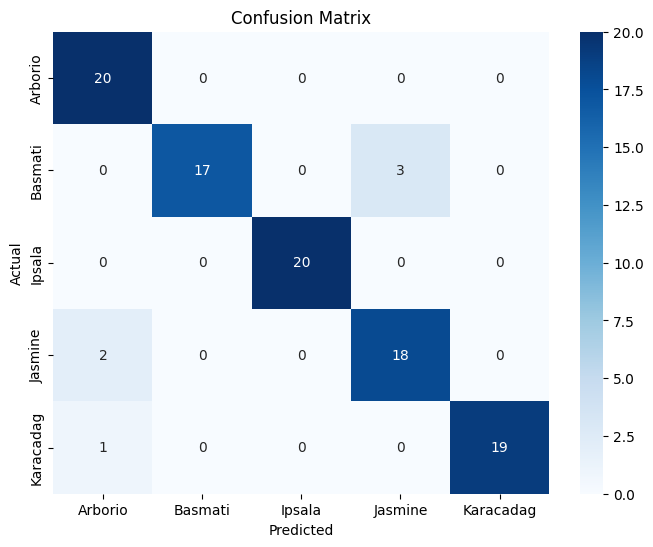

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
test_generator.reset()
Y_pred = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Display Sample Predictions
To show a few sample predictions:


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


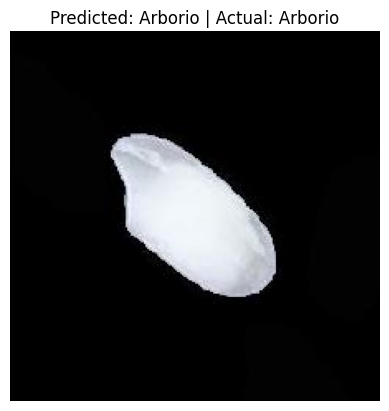

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


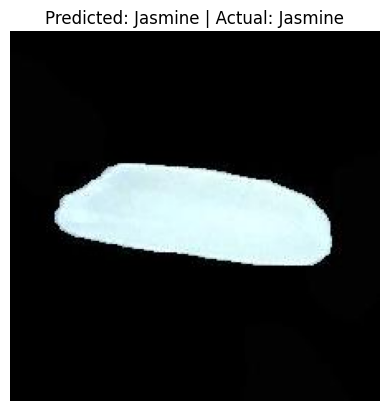

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


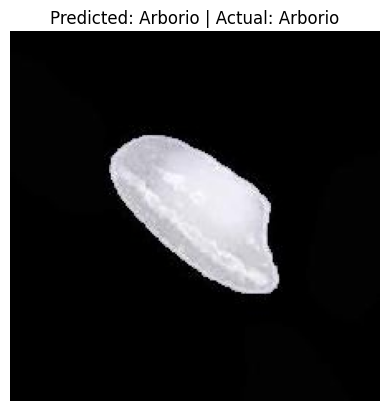

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


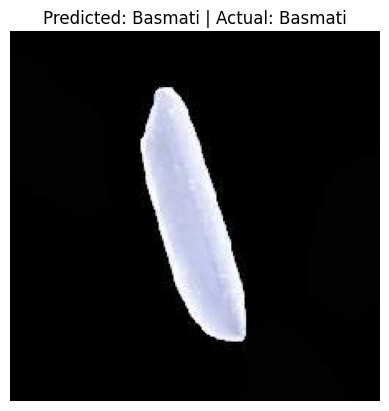

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


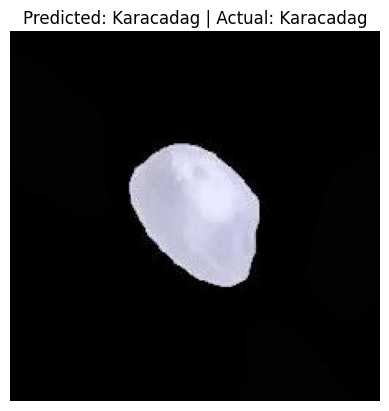

In [21]:
import random
from tensorflow.keras.preprocessing import image

# Show 5 random predictions
sample_indices = random.sample(range(len(test_generator.filenames)), 5)

for idx in sample_indices:
    img_path = test_generator.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    prediction = best_model.predict(img_expanded)
    predicted_class = class_labels[np.argmax(prediction)]
    actual_class = class_labels[y_true[idx]]

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} | Actual: {actual_class}")
    plt.show()

Create the flask_app folder


In [22]:
import os

base_path = "/content/drive/MyDrive/GrainPalette_RiceTypeDetection/flask_app"
os.makedirs(os.path.join(base_path, "templates"), exist_ok=True)
os.makedirs(os.path.join(base_path, "static", "uploaded"), exist_ok=True)

print("✅ Flask app folder structure created.")

✅ Flask app folder structure created.


Install Flask and Dependencies

In [23]:
!pip install flask flask-ngrok tensorflow pillow